<a href="https://colab.research.google.com/github/Polinochka-2/personalisation-model/blob/main/Personalisation_%2B_rest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- ✅  2+ эскиза, отрисованные в Figma/Axure/... и конвертированные в шаблоны jinja2, используемые в сервисе (экспорт в html → расстановка тегов → интеграция)
- ✅ концептуальная модель + код на mongoengine, интегрированный в сервис
- ✅ прототип модели персонализации на основе тестовых данных (коллекция айтемов - эмбеддинги - расстояния) = качество модели должно обеспечивать логичную демонстрацию работы
- ✅ холодный старт (для пользователя) - генерация вариантов (показать полярные варианты)
- ✅ холодный старт - модель пользователя (на основе ввода пользователя посчитать и сохранить его профиль предпочтений)
- ✅  персонализация - фильтрация/сопоставление
- ✅  персонализация - ранжирование (при выводе списка айтемов использовать ранжирование с учетом персонализации), 
- ✅ 4+ содержательно различных методов  для 2+ REST ресурсов (напр. ресурсы Users, Posts)
- ?✅ 4+ behave сценария с реализацией, иллюстрирующие работу системы ИЛИ 4+ тестовых сценария с реализацией, иллюстрирующих работу системы с помощью интерфейсных виджетов

То есть в качестве постов у нас описание фильмов с разными типами жанров: комедия, ужасы и документальный (в каждом по 10 постов)

In [ ]:
!pip install -U flask-restful
!pip install -U flask-apispec
!pip install -U flask-ngrok

In [ ]:
from flask import Flask, request, jsonify, make_response
from flask_restful import Resource, Api
from flask_ngrok import run_with_ngrok
import joblib
import json

Импортируем embeddings

In [ ]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
import pandas as pd

In [ ]:
!pip install dnspython

In [ ]:
!pip install mongoengine

In [ ]:
!pip install umap-learn

In [ ]:
mydb = 'mz4_bmv'
from mongoengine import *
connect(host="mongodb+srv://hci2020.evc7n.mongodb.net",
                 username = "studenthci",
                 password="Kanta!3K1",
                 db = mydb)

#Conceptual model
class Doc(Document):
    text = StringField(required=True)
    topic = StringField(required=True)
    embedding = ListField(FloatField(), max_length=512)

class Users(Document):
  id = StringField(required=True, primary_key = True)
  prefs = ListField(StringField())   

# создаем класс для удобства работы, чтобы при каждом запуске колаба не заносить данные и не считать embeddings
class Topic(Document):
    topic = StringField(required=True)
    embedding = ListField(FloatField(), max_length=512)

Просто добавим одного пользователя в бд

In [ ]:
Users(id = 'polina', prefs = ['comedy', 'horror', 'documentary']).save()

<Users: Users object>

## Импорт данных:

запускать не надо уже, все записалось в бд

In [ ]:
comedy = pd.read_csv('comedy.csv')
comedy['topic'] = 'comedy'

In [ ]:
documentary = pd.read_csv('documentary.csv')
documentary['topic'] = 'documentary'

In [ ]:
horror = pd.read_csv('horror.csv')
horror['topic'] = 'horror'

Записываем эти датасеты в класс Doc

In [ ]:
for index, text in comedy.iterrows():
  Doc(text = text['post'], topic = text['topic'], embedding=embed([text['post']])[0]).save()

In [ ]:
for index, text in documentary.iterrows():
  Doc(text = text['post'], topic = text['topic'], embedding=embed([text['post']])[0]).save()

In [ ]:
for index, text in horror.iterrows():
  Doc(text = text['post'], topic = text['topic'], embedding=embed([text['post']])[0]).save()

## Записываем данные в класс: топик + центр

не надо запускать, уже в бд

In [ ]:
for topic in Doc.objects.distinct(field="topic"):
  Topic(topic=topic, embedding = np.average(embed([doc.text for doc in Doc.objects(topic=topic)]), axis=0)).save()

In [ ]:
for topic in Topic.objects():
  print(topic.topic)
  print(topic.embedding)

## Приведение к 2d + иллюстрация кластеров

In [ ]:
import os, umap
import numpy as np
import pandas as pd
embeddings_all = embed([doc.text for doc in Doc.objects])
u = umap.UMAP().fit(embeddings_all)

coords = u.transform(embeddings_all)


coords = pd.DataFrame(coords)

coords = pd.concat([coords.reset_index(drop=True), pd.Series([doc['topic'] for doc in Doc.objects])], axis=1)
coords.columns=['x','y','topic']

как-то мало данных, то все равно видно, что разные жанры локализуются в разных частях

координаты центров кластеров в новом пространстве

In [ ]:
coords_topics = u.transform([embed.embedding for embed in Topic.objects()])
coords_topics = pd.DataFrame(coords_topics)

In [ ]:
coords_topics = pd.concat([coords_topics.reset_index(drop=True), pd.Series([doc['topic'] for doc in Doc.objects])], axis=1)
coords_topics.columns=['x','y','topic']

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

for t in coords.topic.unique():
  dots_topic = coords[coords.topic == t]
  fig.add_trace(go.Scatter(x=dots_topic.x, y=dots_topic.y,
                    mode='markers',
                    name=str(t)))

fig.add_trace(go.Scatter(x=coords_topics.x, y=coords_topics.y,
                    mode='markers',
                    marker_size = 18,
                    name='center'))

fig.show()

## Холодный старт (для пользователя) - генерация вариантов (показать полярные варианты). И на основе выбора пользователя сохранить пользователя в бд и выдать РАНЖИРОВАННЫЙ СПИСОК либо ФИЛЬТРАЦИЮ

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def pretty_similarity(comp_dict):
  df = pd.DataFrame(cosine_similarity(list(comp_dict.values())))
  df.columns = [key[0:11] for key in comp_dict.keys()]
  df.insert(0, 'doc', [key[0:11] for key in comp_dict.keys()])
  return(df)


In [ ]:
import random
def cold_start():

  similarity = pretty_similarity(dict(zip([topic.topic for topic in Topic.objects()], 
                                          [topic.embedding for topic in Topic.objects()])))
  
  position_min = []
  position_min.append(np.unravel_index(np.argmin(similarity.drop(['doc'], axis=1).values), 
                                       similarity.drop(['doc'], axis=1).shape))

  # следующие топики являются наиболее полярными
  genre_column = similarity.columns[position_min[0][1] + 1]
  genre_row = similarity.doc[position_min[0][0]]

  # поэтому просто показываем по два поста из каждого топика полярного, и один пост из другой, третьей, темы
  dict_coldstart = {}
  dict_coldstart[genre_column] = [random.sample([text.text for text in Doc.objects(topic=genre_column)], 2)]
  dict_coldstart[genre_row] = [random.sample([text.text for text in Doc.objects(topic=genre_row)], 2)]

  third_topic = str([item for item in Doc.objects.distinct(field='topic') if item not in [genre_column, genre_row]])[2:-2] 
  dict_coldstart[third_topic] = random.choice([text.text for text in Doc.objects(topic=third_topic)])

  
  return(dict_coldstart)

In [ ]:
import ipywidgets as widgets
from ipywidgets import AppLayout
from IPython.display import display

Выдача ранжированных постов при колдстарте и сам колдстарт с помощью виджета

In [ ]:
import time

In [ ]:
def show_options(id, whatdo, seed):
  dict_coldstart = cold_start()
  descriptions = []
  items_layout = widgets.Layout(width='auto')
  style = {'description_width': 'initial'}
  box_layout = widgets.Layout(display='flex',
                  flex_flow='column',
                  width='max-content')
  for key, item in dict_coldstart.items():
      if isinstance(item, str):
          descriptions.append(item)
      else:
          descriptions.append(item[0][0])
          descriptions.append(item[0][1])

  w = widgets.SelectMultiple(
      options=descriptions,
      description='Posts',
      disabled=False,
      layout={'width': 'max-content'}
  )

  out = widgets.Output()

  #@out.capture()
  def changed(b):
    chosen_texts = w.value
    # то есть пользователь без предпочтений ничего не выбрал на холодном старте
    if len(chosen_texts) == 0 and len(Users.objects.get(id = id).prefs) == 0:

      with out:
        print("Nothing was chosen. We'll show you more options.")
      show_options(id, whatdo, seed)

    # то есть зарегистрированный пользователь что-то еще выбрал
    elif len(chosen_texts) > 0 and len(Users.objects.get(id = id).prefs) > 0:
      users_prefs = []
      for text in chosen_texts:
        for texts in Doc.objects(text=text):
          if texts.topic not in users_prefs:
            users_prefs.append(texts.topic) 
      for topic in Users.objects.get(id = id).prefs:
        if topic not in users_prefs:
          users_prefs.append(topic)

      updateUser(id, users_prefs)

      with out:
        display(users_prefs)
        # выводим мэтч из тестовой выборки
        if whatdo == 'match':
          display(match(id))
        elif whatdo == 'filter':
        # выводим ранжирование
          display(filter(id, seed))

# если у пользователя есть предпочтения, а мы ему показали холодный старт и он ничего не выбрал
    elif len(chosen_texts) == 0 and len(Users.objects.get(id = id).prefs) > 0:
      users_prefs = Users.objects.get(id = id).prefs
      with out:
        display(users_prefs)
        # выводим мэтч из тестовой выборки
        if whatdo == 'match':
          display(match(id))
        elif whatdo == 'filter':
        # выводим ранжирование
          display(filter(id, seed))


    else:
      users_prefs = []
      for text in chosen_texts:
        for texts in Doc.objects(text=text):
          if texts.topic not in users_prefs:
            users_prefs.append(texts.topic) 
      
      # добавляем этого пользователя с его предпочтениями
      Users(id = id, prefs = users_prefs).save()

      with out:
        display(users_prefs)
        # выводим мэтч из тестовой выборки
        if whatdo == 'match':
          display(match(id))
        elif whatdo == 'filter':
        # выводим ранжирование
          display(filter(id, seed))


  chosen = widgets.Button(description="Chosen", 
                        button_style='info')

  chosen.on_click(changed)

  display(w)
  display(chosen, out)



In [ ]:
show_options('blabla', 'filter', 28)
show_options('blabla', 'match', 28)

SelectMultiple(description='Posts', layout=Layout(width='max-content'), options=('His House \nAfter making a h…

Button(button_style='info', description='Chosen', style=ButtonStyle())

Output()

SelectMultiple(description='Posts', layout=Layout(width='max-content'), options=('Army of the Dead\nFollowing …

Button(button_style='info', description='Chosen', style=ButtonStyle())

Output()

## Персонализация - ранжирование (при выводе списка айтемов использовать ранжирование с учетом персонализации)

In [ ]:
def filter(user_id, seeds):

  Docs = [dict(text=doc.text, topic=doc.topic) for doc in Doc.objects()]
  e = embed([doc['text'] for doc in Docs])

  for i in range(0, len(Docs)):
    Docs[i]['embedding'] = np.array(e[i]).tolist()

  np.random.seed(seeds)
  # 28 - horror, documentary
  # 34 - comedy, horror
  np.random.choice(len(Docs), size=5, replace=False).tolist() #случайные индексы

  Test_docs = [Docs[i] for i in np.random.choice(len(Docs), size=5, replace=False).tolist()]
  e = [test_doc['embedding'] for test_doc in Test_docs]


  users_pref = Users.objects.get(id=user_id).prefs
  user_embed = []
  result = pd.DataFrame(Test_docs, columns=['embedding', 'text', 'topic'])

  # поскольку преференсов может быть несколько
  for i in range(len(users_pref)):
    user_embed.append(Topic.objects.get(topic = users_pref[i]).embedding)
    e.insert(0, Topic.objects.get(topic = users_pref[i]).embedding)
    sim = cosine_similarity(e)
    sim[0,1:sim.shape[1]]
    sim_rank = sim[0,1:sim.shape[1]].tolist()
    result['rank_' + str(i)] = pd.Series(sim_rank)

    #удаляем последний элемент из e, чтобы он не учитывался при подсчете схожести для след топика
    e = e[:-1]

  # считаем среднее по рангам
  list_ranks = list(result)[3:]
  result['mean_ranks'] = result[list_ranks].sum(axis=1) / len(list_ranks)

  result = result.sort_values(by='mean_ranks', ascending=False)

  return result



In [ ]:
filter('polina', 6)

,embedding,text,topic,rank_0,rank_1,mean_ranks
1,"[-0.003983712755143642, -0.06977173686027527, ...",Stick It\nHaley is a naturally gifted athlete ...,comedy,0.529621,0.732427,0.631024
0,"[0.025754414498806, 0.055689916014671326, -0.0...",The Dark and the Wicked\nOn a secluded farm in...,horror,0.493841,0.710620,0.602231
2,"[0.006991771515458822, -0.014094514772295952, ...",The Magic Of Belle Isle \nIn an effort to tap ...,comedy,0.552698,0.343276,0.447987
4,"[-0.00018745928537100554, -0.04752025753259659...",Jakob's Wife\nAnne is married to a small-town ...,horror,0.433234,0.109464,0.271349
3,"[0.03273164853453636, -0.005644201301038265, -...",Unacknowledged\nAn exploration of the Alien pr...,documentary,0.086841,0.449243,0.268042


## Персонализация - фильтрация / сопоставление

Выводит на основе пользовательских предпочтений все посты из тестовой выборки, которые соответствуют выбранным им топикам

In [ ]:
def match(user_id):

  Docs = [dict(text=doc.text, topic=doc.topic) for doc in Doc.objects()]
  e = embed([doc['text'] for doc in Docs])

  for i in range(0, len(Docs)):
    Docs[i]['embedding'] = np.array(e[i]).tolist()


  np.random.choice(len(Docs), size=5, replace=False).tolist() #случайные индексы

  Test_docs = [Docs[i] for i in np.random.choice(len(Docs), size=5, replace=False).tolist()]
  e = [test_doc['embedding'] for test_doc in Test_docs]


  users_pref = Users.objects.get(id=user_id).prefs

  result = pd.DataFrame(Test_docs, columns=['embedding', 'text', 'topic'])
  matched_posts = result[result['topic'].isin(users_pref)]


  return matched_posts

match('polina')

,embedding,text,topic
0,"[-0.015114672482013702, 0.023967772722244263, ...",Black Box \nAfter losing his wife and his memo...,horror
1,"[-0.003983712755143642, -0.06977173686027527, ...",Stick It\nHaley is a naturally gifted athlete ...,comedy
2,"[-0.019362211227416992, -0.04234694689512253, ...",Army of the Dead\nFollowing a zombie outbreak ...,horror
3,"[0.006991771515458822, -0.014094514772295952, ...",The Magic Of Belle Isle \nIn an effort to tap ...,comedy


## 4+ содержательно различных методов  для 2+ REST ресурсов (напр. ресурсы Users, Posts)

### Ресурс Posts (то есть в нашем случае это класс Doc, где хранятся все посты, топики и их эмбединги):


#### Метод "создать пост":


In [ ]:
def createPost(text, topic):
  Doc(text=text,
      topic=topic,
      embedding=embed([text])[0]).save()

In [ ]:
createPost("My Dad's Christmas Date It’s Christmas and the charming city of York home to Jules 16 and her Dad David is decked out ready for the festive season. In many ways David and Jules’ relationship is no different from that of most fathers and their sixteen-year-old daughters. He struggles to understand her she refuses to communicate with him. He wants to be involved in her life she wants her own space. In one important respect however David and Jules share a profound bond: the death of Jules’ mum and David’s wife in a car crash two years before. With both struggling to cope with everyday life in the shadow of their loss Jules inspired by happy memories of her mum decides to take matters into her own hands.",
           'comedy')

#### Метод "показать первый пост по определенной теме":

In [ ]:
def showPost(topic):
  text = [doc.text for doc in Doc.objects(topic=topic)][0]
  embed = Doc.objects.get(text=text).embedding
  return [topic, text, embed]

In [ ]:
topic = 'comedy'

In [ ]:
showPost(topic)

#### Метод "удалить пост":

In [ ]:
def deletePost(text):
  Doc.objects(text=text).delete()

In [ ]:
text = "My Dad's Christmas Date It’s Christmas and the charming city of York home to Jules 16 and her Dad David is decked out ready for the festive season. In many ways David and Jules’ relationship is no different from that of most fathers and their sixteen-year-old daughters. He struggles to understand her she refuses to communicate with him. He wants to be involved in her life she wants her own space. In one important respect however David and Jules share a profound bond: the death of Jules’ mum and David’s wife in a car crash two years before. With both struggling to cope with everyday life in the shadow of their loss Jules inspired by happy memories of her mum decides to take matters into her own hands."

In [ ]:
deletePost(text)

#### Методы "создать пост", "показать первый пост по определенной теме", "удалить пост" , используя Flask

In [ ]:

app = Flask(__name__)
run_with_ngrok(app) 
 
api = Api(app)


class Postcreate(Resource):
  
    def post(self):
      json_data = request.get_json()
      text = json_data['post']
      topic = json_data['topic']
      createPost(text, topic)

      return make_response(jsonify(Status = 'Done', Message = "Post's been added in database"), 201)


    def get(self):
      topic = request.args.get('topic')
      r = showPost(topic)
      return make_response(jsonify(r))


    def delete(self):
      json_data = request.get_json()
      text = json_data['post']
      deletePost(text)

      return make_response(jsonify(Status = 'Done', Message = "The post's been deleted"), 201)



api.add_resource(Postcreate, '/')

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://d4a5e63e5cbb.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


Пример файла json для работы метода post:



```
{"post":"Unbreakable Kimmy Schmidt: Kimmy vs. the Reverend\nKimmy's a famous author and she's about to marry a prince! But first she has to foil the Reverend's evil plot. It's your move: What should Kimmy do next?",
"topic":"comedy"}
```



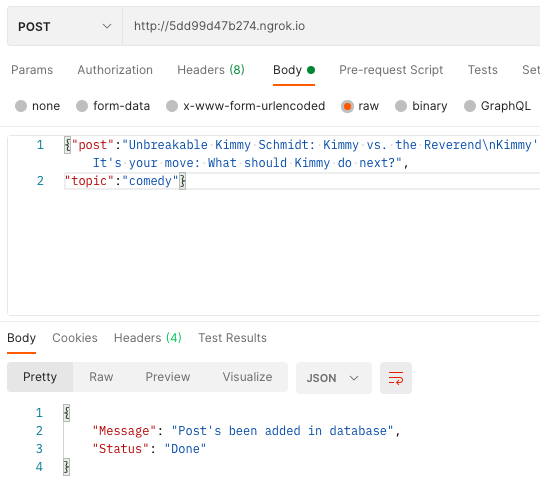

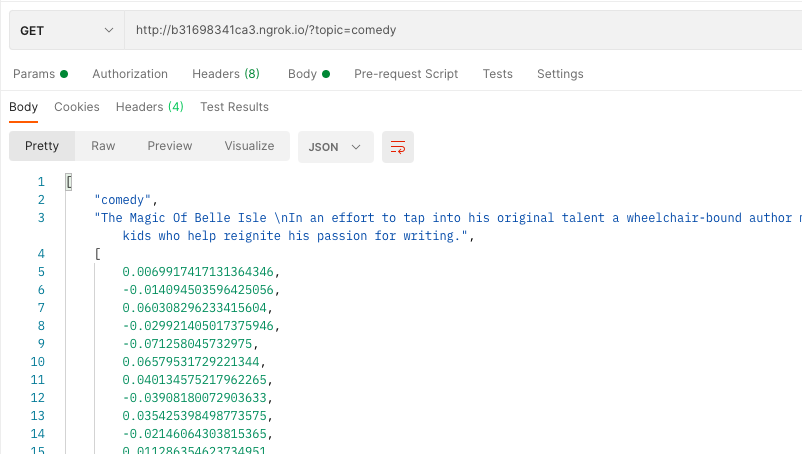

Json файл для удаления поста:

```
{"post":"Unbreakable Kimmy Schmidt: Kimmy vs. the Reverend\nKimmy's a famous author and she's about to marry a prince! But first she has to foil the Reverend's evil plot. It's your move: What should Kimmy do next?"}
```



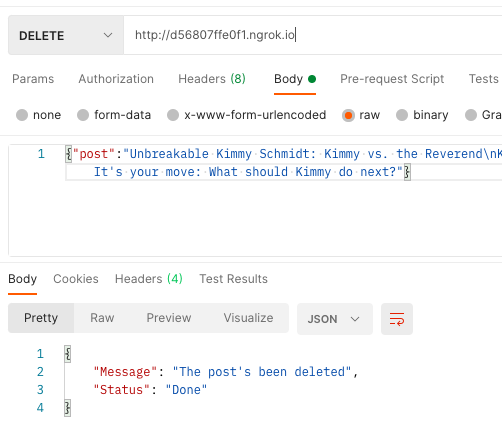

#### Метод "показать ранжированный персонализированный список":

Это функция filter, описанная в разделе выше.

#### Метод "показать отфильтрованный персонализированный список" 

Это функция match

### Ресурс Users:

#### Метод "создать нового пользователя" (то есть можем создать пользователя и без предпочтений):

In [ ]:
def createUser(user_id, prefs = None):
  if prefs is not None:
    Users(id = user_id, prefs = prefs).save()
  else:
    Users(id = user_id).save()

In [ ]:
createUser('polina', ['comedy', 'horror'])

In [ ]:
createUser('anna')

#### Метод "показать существующего пользователя":

In [ ]:
def showUser(user_id):
  prefs = Users.objects.get(id=user_id).prefs
  return {user_id: prefs}

In [ ]:
showUser('polina')

{'polina': ['comedy', 'horror']}

#### Метод "обновить информацию о пользователе, его предпочтения по жанрам":

In [ ]:
def updateUser(user_id, prefs=None):
  if prefs is not None:
    Users(id = user_id, prefs = prefs).save()
  else:
    Users(id = user_id).save()

In [ ]:
updateUser('anna', ['horror', 'documentary'])

#### Метод "удалить пользователя из базы данных":

In [ ]:
def deleteUser(user_id):
  Users.objects(id=user_id).delete()

In [ ]:
deleteUser('anna')

#### Методы "создать нового пользователя", "показать существующего пользователя ", "обновить информацию о пользователе", "удалить пользователя из базы данных" , используя Flask

In [ ]:
for user in Users.objects():
  print(user.id)
  print(user.prefs)

polina
['comedy', 'horror']


In [ ]:
app = Flask(__name__)
run_with_ngrok(app) 
 
api = Api(app)


class Usercreate(Resource):
  
    def post(self):
      json_data = request.get_json()
      user = json_data['id']
      prefs = json_data['prefs']
      createUser(user, prefs)

      return make_response(jsonify(Status = 'Done', Message = "User's been added in database"), 201)


    def get(self):
      user = request.args.get('id')
      r = showUser(user)
      return make_response(jsonify(r))

    # обновление информации о пользователе
    def put(self):
      json_data = request.get_json()
      user = json_data['id']
      prefs = json_data['prefs']
      updateUser(user, prefs)

      return make_response(jsonify(Status = 'Done', Message = "User's preferences have been updated"), 201)


    def delete(self):
      json_data = request.get_json()
      user = json_data['id']
      deleteUser(user)

      return make_response(jsonify(Status = 'Done', Message = "The user's been deleted"), 201)



api.add_resource(Postcreate, '/')

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://8bb8ad44753c.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [23/Jun/2021 11:27:01] "POST / HTTP/1.1" 201 -
INFO:werkzeug:127.0.0.1 - - [23/Jun/2021 11:27:45] "GET /?id=anna HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Jun/2021 11:28:25] "PUT / HTTP/1.1" 201 -
INFO:werkzeug:127.0.0.1 - - [23/Jun/2021 11:28:46] "DELETE /?id=anna HTTP/1.1" 201 -


Пример файла json для работы метода post:


```
{"id":"anna",
"prefs":["documentary", "horror"]}
```



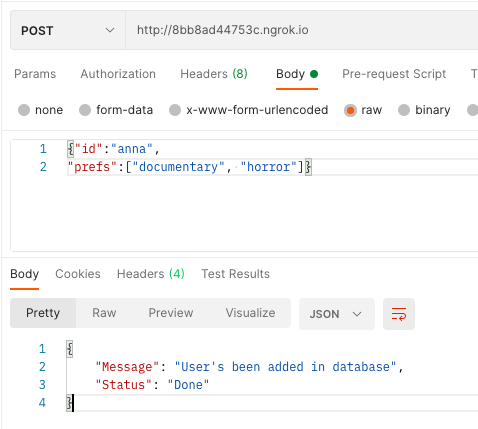

Метод GET для вывода информации о пользователе:
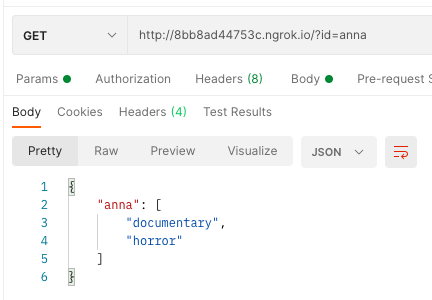

Метод PUT для изменения предпочтений пользователя с:


```
{"id":"anna",
"prefs":["documentary", "horror"]}
```


на: 

```
{"id":"anna",
"prefs":["documentary", "horror", "comedy"]}
```



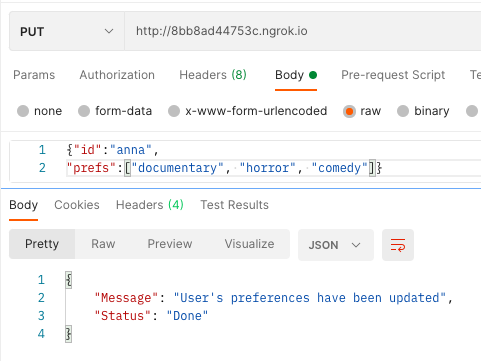

Удаление пользователя из базы данных:

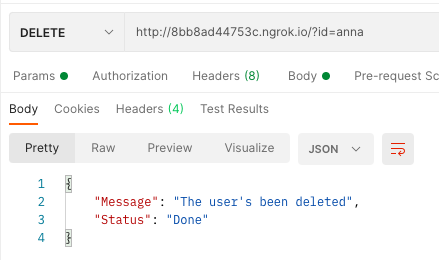

## Импорт шаблонов из фигмы

### Шаблон профиля с предпочтениями

In [ ]:
from jinja2 import Template

In [ ]:
template_prof = '''
<!DOCTYPE html>
<html>

<head>
    <link href="https://fonts.googleapis.com/css?family=SF+Pro+Display&display=swap" rel="stylesheet" />
    <link href="./main.css" rel="stylesheet" />
    <title>Document</title>
</head>
  <style type="text/css">
* {
  box-sizing: border-box;
}
body {
  font-size: 14px;
}
.v175_864 {
  width: 100%;
  height: 1024px;
  background: rgba(255,255,255,1);
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  overflow: hidden;
}
.v175_865 {
  width: 212px;
  height: 182px;
  background: url("../images/v175_865.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 139px;
  left: 615px;
  overflow: hidden;
}
.v175_866 {
  width: 212px;
  height: 182px;
  background: url("../images/v175_866.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  overflow: hidden;
}
.v175_867 {
  width: 125px;
  height: 125px;
  background: url("../images/v175_867.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 0px;
  left: 43px;
  overflow: hidden;
}
.v175_868 {
  width: 80px;
  height: 30px;
  background: url("../images/v175_868.png");
  opacity: 1;
  position: absolute;
  top: 79px;
  left: 22px;
  border: 2px solid rgba(0,0,0,1);
}
.v175_869 {
  width: 40px;
  height: 40px;
  background: url("../images/v175_869.png");
  opacity: 1;
  position: absolute;
  top: 19px;
  left: 42px;
  border: 2px solid rgba(0,0,0,1);
}
.v175_870 {
  width: 125px;
  height: 125px;
  background: url("../images/v175_870.png");
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  border-radius: 50%;
}
.v175_873 {
  width: 212px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 139px;
  left: 0px;
  font-family: SF Pro Display;
  font-weight: Regular;
  font-size: 36px;
  opacity: 1;
  text-align: center;
}
.v175_874 {
  width: 154px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 411px;
  left: 643px;
  font-family: SF Pro Display;
  font-weight: Light;
  font-size: 26px;
  opacity: 1;
  text-align: center;
}
.v175_875 {
  width: 202px;
  height: 59px;
  background: url("../images/v175_875.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 54px;
  left: 1160px;
  overflow: hidden;
}
.v175_876 {
  width: 202px;
  height: 59px;
  background: url("../images/v175_876.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  border: 1px solid rgba(0,0,0,1);
  overflow: hidden;
}
.v175_877 {
  width: 136px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 13px;
  left: 32px;
  font-family: SF Pro Display;
  font-weight: Regular;
  font-size: 28px;
  opacity: 1;
  text-align: center;
}
.v175_878 {
  width: 252px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 345px;
  left: 594px;
  font-family: SF Pro Display;
  font-weight: Light;
  font-size: 32px;
  opacity: 1;
  text-align: center;
}
.v175_879 {
  width: 452px;
  height: 178px;
  background: url("../images/v175_879.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 403px;
  left: 494px;
  border: 1px solid rgba(0,0,0,1);
  overflow: hidden;
}
* {
  box-sizing: border-box;
}
body {
  font-size: 14px;
}
.v175_864 {
  width: 100%;
  height: 1024px;
  background: rgba(255,255,255,1);
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  overflow: hidden;
}
.v175_865 {
  width: 212px;
  height: 182px;
  background: url("../images/v175_865.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 139px;
  left: 615px;
  overflow: hidden;
}
.v175_866 {
  width: 212px;
  height: 182px;
  background: url("../images/v175_866.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  overflow: hidden;
}
.v175_867 {
  width: 125px;
  height: 125px;
  background: url("../images/v175_867.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 0px;
  left: 43px;
  overflow: hidden;
}
.v175_868 {
  width: 80px;
  height: 30px;
  background: url("../images/v175_868.png");
  opacity: 1;
  position: absolute;
  top: 79px;
  left: 22px;
  border: 2px solid rgba(0,0,0,1);
}
.v175_869 {
  width: 40px;
  height: 40px;
  background: url("../images/v175_869.png");
  opacity: 1;
  position: absolute;
  top: 19px;
  left: 42px;
  border: 2px solid rgba(0,0,0,1);
}
.v175_870 {
  width: 125px;
  height: 125px;
  background: url("../images/v175_870.png");
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  border-radius: 50%;
}
.v175_873 {
  width: 212px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 139px;
  left: 0px;
  font-family: SF Pro Display;
  font-weight: Regular;
  font-size: 36px;
  opacity: 1;
  text-align: center;
}
.v175_874 {
  width: 154px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 411px;
  left: 643px;
  font-family: SF Pro Display;
  font-weight: Light;
  font-size: 26px;
  opacity: 1;
  text-align: center;
}
.v175_875 {
  width: 202px;
  height: 59px;
  background: url("../images/v175_875.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 54px;
  left: 1160px;
  overflow: hidden;
}
.v175_876 {
  width: 202px;
  height: 59px;
  background: url("../images/v175_876.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  border: 1px solid rgba(0,0,0,1);
  overflow: hidden;
}
.v175_877 {
  width: 136px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 13px;
  left: 32px;
  font-family: SF Pro Display;
  font-weight: Regular;
  font-size: 28px;
  opacity: 1;
  text-align: center;
}
.v175_878 {
  width: 252px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 345px;
  left: 594px;
  font-family: SF Pro Display;
  font-weight: Light;
  font-size: 32px;
  opacity: 1;
  text-align: center;
}
.v175_879 {
  width: 452px;
  height: 178px;
  background: url("../images/v175_879.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 403px;
  left: 494px;
  border: 1px solid rgba(0,0,0,1);
  overflow: hidden;
}


  </style>

<body>
<div class="v175_864">
<div class="v175_865">
<div class="v175_866">
<div class="v175_867">
<div class="v175_868"></div>
<div class="v175_869"></div>
<div class="v175_870"></div></div>
<span class="v175_873">

{{user_id}}

</span></div></div>
<span class="v175_874">

  <ul>    {% for pref in prefs %}
  <li>{{ pref }}</li>
      {% endfor %} </ul>

</span>
<div class="v175_875"><div class="v175_876"></div>
<span class="v175_877">Edit profile</span></div>
<span class="v175_878">Preferred genres</span><div class="v175_879"></div></div></body>

</html>
'''

In [ ]:
tuser_prof = Template(template_prof)
display(widgets.HTML(tuser_prof.render(user_id="polina", prefs = Users.objects.get(id="polina").prefs)))

HTML(value='\n<!DOCTYPE html>\n<html>\n\n<head>\n    <link href="https://fonts.googleapis.com/css?family=SF+Pr…

### Шаблон холодного старта

In [ ]:
template_cold = '''
<!DOCTYPE html>
<html>

<head>
    <link href="https://fonts.googleapis.com/css?family=SF+Pro+Display&display=swap" rel="stylesheet" />
    <link href="./main-3.css" rel="stylesheet" />
    <title>Document</title>
</head>
  <style type="text/css">
* {
  box-sizing: border-box;
}
body {
  font-size: 14px;
}
.v175_880 {
  width: 100%;
  height: 1428px;
  background: rgba(255,255,255,1);
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  overflow: hidden;
}
.v175_881 {
  width: 286px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 104px;
  left: 577px;
  font-family: SF Pro Display;
  font-weight: Regular;
  font-size: 68px;
  opacity: 1;
  text-align: left;
}
.v175_882 {
  width: 587px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 199px;
  left: 427px;
  font-family: SF Pro Display;
  font-weight: Light;
  font-size: 36px;
  opacity: 1;
  text-align: center;
}
.v175_883 {
  width: 587px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 1312px;
  left: 427px;
  font-family: SF Pro Display;
  font-weight: Light;
  font-size: 20px;
  opacity: 1;
  text-align: center;
}
.v175_884 {
  width: 184px;
  height: 59px;
  background: url("../images/v175_884.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 1203px;
  left: 628px;
  overflow: hidden;
}
.v175_885 {
  width: 184px;
  height: 59px;
  background: url("../images/v175_885.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  border: 1px solid rgba(0,0,0,1);
  overflow: hidden;
}
.v175_886 {
  width: 59px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 13px;
  left: 62px;
  font-family: SF Pro Display;
  font-weight: Regular;
  font-size: 28px;
  opacity: 1;
  text-align: center;
}
.v175_887 {
  width: 308px;
  height: 285px;
  background: url("../images/v175_887.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 559px;
  left: 58px;
  overflow: hidden;
}
.v175_888 {
  width: 308px;
  height: 285px;
  background: url("../images/v175_888.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  overflow: hidden;
}
.v175_889 {
  width: 308px;
  height: 285px;
  background: url("../images/v175_889.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  border: 1px solid rgba(0,0,0,1);
  border-top-left-radius: 15px;
  border-top-right-radius: 15px;
  border-bottom-left-radius: 15px;
  border-bottom-right-radius: 15px;
  overflow: hidden;
}
.v175_890 {
  width: 262px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 25px;
  left: 23px;
  font-family: SF Pro Display;
  font-weight: Light;
  font-size: 22px;
  opacity: 1;
  text-align: center;
}
.v175_892 {
  width: 308px;
  height: 305px;
  background: url("../images/v175_892.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 396px;
  left: 397px;
  overflow: hidden;
}
.v175_893 {
  width: 308px;
  height: 305px;
  background: url("../images/v175_893.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  overflow: hidden;
}
.v175_894 {
  width: 308px;
  height: 305px;
  background: url("../images/v175_894.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  border: 1px solid rgba(0,0,0,1);
  border-top-left-radius: 15px;
  border-top-right-radius: 15px;
  border-bottom-left-radius: 15px;
  border-bottom-right-radius: 15px;
  overflow: hidden;
}
.v175_895 {
  width: 262px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 26px;
  left: 23px;
  font-family: SF Pro Display;
  font-weight: Light;
  font-size: 22px;
  opacity: 1;
  text-align: center;
}
.v175_897 {
  width: 308px;
  height: 285px;
  background: url("../images/v175_897.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 868px;
  left: 566px;
  overflow: hidden;
}
.v175_898 {
  width: 308px;
  height: 285px;
  background: url("../images/v175_898.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  overflow: hidden;
}
.v175_899 {
  width: 308px;
  height: 285px;
  background: url("../images/v175_899.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  border: 1px solid rgba(0,0,0,1);
  border-top-left-radius: 15px;
  border-top-right-radius: 15px;
  border-bottom-left-radius: 15px;
  border-bottom-right-radius: 15px;
  overflow: hidden;
}
.v175_900 {
  width: 262px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 27px;
  left: 23px;
  font-family: SF Pro Display;
  font-weight: Light;
  font-size: 22px;
  opacity: 1;
  text-align: center;
}
.v175_902 {
  width: 308px;
  height: 299px;
  background: url("../images/v175_902.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 402px;
  left: 737px;
  overflow: hidden;
}
.v175_903 {
  width: 308px;
  height: 299px;
  background: url("../images/v175_903.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  overflow: hidden;
}
.v175_904 {
  width: 308px;
  height: 299px;
  background: url("../images/v175_904.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  border: 1px solid rgba(0,0,0,1);
  border-top-left-radius: 15px;
  border-top-right-radius: 15px;
  border-bottom-left-radius: 15px;
  border-bottom-right-radius: 15px;
  overflow: hidden;
}
.v175_905 {
  width: 262px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 6px;
  left: 23px;
  font-family: SF Pro Display;
  font-weight: Light;
  font-size: 22px;
  opacity: 1;
  text-align: center;
}
.v175_907 {
  width: 308px;
  height: 276px;
  background: url("../images/v175_907.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 568px;
  left: 1077px;
  overflow: hidden;
}
.v175_908 {
  width: 308px;
  height: 276px;
  background: url("../images/v175_908.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  overflow: hidden;
}
.v175_909 {
  width: 308px;
  height: 276px;
  background: url("../images/v175_909.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  border: 1px solid rgba(0,0,0,1);
  border-top-left-radius: 15px;
  border-top-right-radius: 15px;
  border-bottom-left-radius: 15px;
  border-bottom-right-radius: 15px;
  overflow: hidden;
}
.v175_910 {
  width: 262px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 22px;
  left: 23px;
  font-family: SF Pro Display;
  font-weight: Light;
  font-size: 22px;
  opacity: 1;
  text-align: center;
}
.name {
  color: #fff;
}

  </style>

<body>

<div class="v175_880">
<span class="v175_881">Welcome!</span>
<span class="v175_882">What movies do you like the most?</span>
<span class="v175_883">Already have an account? Sign in to see your recommendations</span>
<div class="v175_884"><div class="v175_885"></div>
<span class="v175_886">Chosen</span></div>
<div class="v175_887"><div class="v175_888"><div class="v175_889"></div>
<span class="v175_890">

{{descriptions[0]}}



</span></div></div>

<div class="v175_892"><div class="v175_893"><div class="v175_894"></div>
<span class="v175_895"> 

{{descriptions[1]}}

</span></div></div>


<div class="v175_897"><div class="v175_898"><div class="v175_899"></div>
<span class="v175_900">

{{descriptions[2]}}



</span></div></div>
<div class="v175_902"><div class="v175_903"><div class="v175_904"></div>
<span class="v175_905">

{{descriptions[3]}}

</span></div></div>

<div class="v175_907"><div class="v175_908"><div class="v175_909"></div>
<span class="v175_910">

{{descriptions[4]}}


</span></div></div><div class="name"></div></div>

</body>
</html>
'''

Например, создадим пользователя нового, у котороого нет предпочтений, и запустим для него coldstart

In [ ]:
dict_coldstart = cold_start()
descriptions = []
for key, item in dict_coldstart.items():
    if isinstance(item, str):
        descriptions.append(item)
    else:
        descriptions.append(item[0][0])
        descriptions.append(item[0][1])

In [ ]:
tuser_cold = Template(template_cold)
display(widgets.HTML(tuser_cold.render(descriptions = descriptions)))

HTML(value='\n<!DOCTYPE html>\n<html>\n\n<head>\n    <link href="https://fonts.googleapis.com/css?family=SF+Pr…

### Шаблон выдачи финального ранжирования

In [ ]:
template_ans = '''
<!DOCTYPE html>
<html>

<head>
    <link href="https://fonts.googleapis.com/css?family=SF+Pro+Display&display=swap" rel="stylesheet" />
    <link href="./main-2.css" rel="stylesheet" />
    <title>Document</title>
</head>
  <style type="text/css">
* {
  box-sizing: border-box;
}
body {
  font-size: 14px;
}
.v177_0 {
  width: 100%;
  height: 927px;
  background: rgba(255,255,255,1);
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  overflow: hidden;
}
.v178_0 {
  width: 857px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 65px;
  left: 291px;
  font-family: SF Pro Display;
  font-weight: Regular;
  font-size: 48px;
  opacity: 1;
  text-align: center;
}
.v178_1 {
  width: 739px;
  height: 102px;
  background: url("../images/v178_1.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 216px;
  left: 350px;
  overflow: hidden;
}
.v178_2 {
  width: 739px;
  height: 102px;
  background: url("../images/v178_2.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  overflow: hidden;
}
.v178_3 {
  width: 739px;
  height: 102px;
  background: url("../images/v178_3.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  border: 1px solid rgba(0,0,0,1);
  border-top-left-radius: 15px;
  border-top-right-radius: 15px;
  border-bottom-left-radius: 15px;
  border-bottom-right-radius: 15px;
  overflow: hidden;
}
.v178_4 {
  width: 686px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 19px;
  left: 27px;
  font-family: SF Pro Display;
  font-weight: Light;
  font-size: 18px;
  opacity: 1;
  text-align: center;
}
.v178_6 {
  width: 739px;
  height: 102px;
  background: url("../images/v178_6.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 353px;
  left: 350px;
  overflow: hidden;
}
.v178_7 {
  width: 739px;
  height: 102px;
  background: url("../images/v178_7.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  overflow: hidden;
}
.v178_8 {
  width: 739px;
  height: 102px;
  background: url("../images/v178_8.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: relative;
  top: 0px;
  left: 0px;
  border: 1px solid rgba(0,0,0,1);
  border-top-left-radius: 15px;
  border-top-right-radius: 15px;
  border-bottom-left-radius: 15px;
  border-bottom-right-radius: 15px;
  overflow: hidden;
}
.v178_9 {
  width: 686px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 9px;
  left: 27px;
  font-family: SF Pro Display;
  font-weight: Light;
  font-size: 18px;
  opacity: 1;
  text-align: center;
}
.v178_11 {
  width: 739px;
  height: 102px;
  background: url("../images/v178_11.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 490px;
  left: 351px;
  overflow: hidden;
}
.v178_12 {
  width: 739px;
  height: 102px;
  background: url("../images/v178_12.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 0px;
  left: 0px;
  overflow: hidden;
}
.v178_13 {
  width: 739px;
  height: 102px;
  background: url("../images/v178_13.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 0px;
  left: 0px;
  border: 1px solid rgba(0,0,0,1);
  border-top-left-radius: 15px;
  border-top-right-radius: 15px;
  border-bottom-left-radius: 15px;
  border-bottom-right-radius: 15px;
  overflow: hidden;
}
.v178_14 {
  width: 686px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 7px;
  left: 27px;
  font-family: SF Pro Display;
  font-weight: Light;
  font-size: 18px;
  opacity: 1;
  text-align: center;
}
.v178_16 {
  width: 739px;
  height: 102px;
  background: url("../images/v178_16.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 627px;
  left: 351px;
  overflow: hidden;
}
.v178_17 {
  width: 739px;
  height: 102px;
  background: url("../images/v178_17.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 0px;
  left: 0px;
  overflow: hidden;
}
.v178_18 {
  width: 739px;
  height: 102px;
  background: url("../images/v178_18.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 0px;
  left: 0px;
  border: 1px solid rgba(0,0,0,1);
  border-top-left-radius: 15px;
  border-top-right-radius: 15px;
  border-bottom-left-radius: 15px;
  border-bottom-right-radius: 15px;
  overflow: hidden;
}
.v178_19 {
  width: 686px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 5px;
  left: 27px;
  font-family: SF Pro Display;
  font-weight: Light;
  font-size: 18px;
  opacity: 1;
  text-align: center;
}
.v178_21 {
  width: 739px;
  height: 102px;
  background: url("../images/v178_21.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 764px;
  left: 351px;
  overflow: hidden;
}
.v178_22 {
  width: 739px;
  height: 102px;
  background: url("../images/v178_22.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 0px;
  left: 0px;
  overflow: hidden;
}
.v178_23 {
  width: 739px;
  height: 102px;
  background: url("../images/v178_23.png");
  background-repeat: no-repeat;
  background-position: center center;
  background-size: cover;
  opacity: 1;
  position: absolute;
  top: 0px;
  left: 0px;
  border: 1px solid rgba(0,0,0,1);
  border-top-left-radius: 15px;
  border-top-right-radius: 15px;
  border-bottom-left-radius: 15px;
  border-bottom-right-radius: 15px;
  overflow: hidden;
}
.v178_24 {
  width: 686px;
  color: rgba(0,0,0,1);
  position: absolute;
  top: 7px;
  left: 27px;
  font-family: SF Pro Display;
  font-weight: Light;
  font-size: 18px;
  opacity: 1;
  text-align: center;
}
  </style>

<body>

<div class="v177_0">
<span class="v178_0">Look, you might be interested in something!</span><div class="v178_1">
<div class="v178_2"><div class="v178_3"></div>
<span class="v178_4">

{{result.text.iloc[0]}}


</span></div></div><div class="v178_6"><div class="v178_7"><div class="v178_8"></div>
<span class="v178_9">

{{result.text.iloc[1]}}

</span></div></div>
<div class="v178_11"><div class="v178_12"><div class="v178_13"></div>
<span class="v178_14">

{{result.text.iloc[2]}}

</span></div></div><div class="v178_16"><div class="v178_17"><div class="v178_18"></div>

<span class="v178_19">

{{result.text.iloc[3]}}

</span></div></div><div class="v178_21"><div class="v178_22"><div class="v178_23"></div>

<span class="v178_24">

{{result.text.iloc[4]}}

</span></div></div></div></body>
</html>
'''

In [ ]:
result = filter('polina', 33)

tuser_ans = Template(template_ans)
display(widgets.HTML(tuser_ans.render(result = result)))

HTML(value='\n<!DOCTYPE html>\n<html>\n\n<head>\n    <link href="https://fonts.googleapis.com/css?family=SF+Pr…

## Сценарии (инд. часть Барсук П.)

### Сценарий 1: Пользователь уже зарегистрирован в системе, и у него нет ни одного предпочтения.

Наш пользователь

In [ ]:
createUser('Klava')

In [ ]:
user1 = showUser('Klava')
display(widgets.HTML(tuser_prof.render(user_id=next(iter(user1)), prefs = Users.objects.get(id=next(iter(user1))).prefs)))

HTML(value='\n<!DOCTYPE html>\n<html>\n\n<head>\n    <link href="https://fonts.googleapis.com/css?family=SF+Pr…

Показываем ему холодный старт еще раз, а после уже выводим ранжированный список:

In [ ]:
show_options(next(iter(user1)), 'filter', 11)


SelectMultiple(description='Posts', layout=Layout(width='max-content'), options=('Jakob\'s Wife\nAnne is marri…

Button(button_style='info', description='Chosen', style=ButtonStyle())

Output()

То есть пользователь увидит после выбора постов следующий экран

In [ ]:

display(widgets.HTML(tuser_ans.render(result = filter(next(iter(user1)), 11))))

HTML(value='\n<!DOCTYPE html>\n<html>\n\n<head>\n    <link href="https://fonts.googleapis.com/css?family=SF+Pr…

Таким образом, пользователь выбрал два поста, которые относятся к жанрам horror и documentary, а дальше ему на основе этих жанров выдали ранжированный список описаний фильмов.

Стоит заметить, что тут профиль пользователя изменился после холодного старта:

In [ ]:
display(widgets.HTML(tuser_prof.render(user_id=next(iter(user1)), prefs = Users.objects.get(id=next(iter(user1))).prefs)))

HTML(value='\n<!DOCTYPE html>\n<html>\n\n<head>\n    <link href="https://fonts.googleapis.com/css?family=SF+Pr…

### Сценарий 2:  У нас в системе есть пользователь без выбранных предпочтений по жанрам. Ему был показан колдстарт, но он ничего не выбрал.

In [ ]:
createUser('Marfa')

In [ ]:
user2 = showUser('Marfa')
display(widgets.HTML(tuser_prof.render(user_id=next(iter(user2)), prefs = Users.objects.get(id=next(iter(user2))).prefs)))

HTML(value='\n<!DOCTYPE html>\n<html>\n\n<head>\n    <link href="https://fonts.googleapis.com/css?family=SF+Pr…

In [ ]:
show_options(next(iter(user2)), 'filter', 5)

SelectMultiple(description='Posts', layout=Layout(width='max-content'), options=('Black Box \nAfter losing his…

Button(button_style='info', description='Chosen', style=ButtonStyle())

Output()

SelectMultiple(description='Posts', layout=Layout(width='max-content'), options=('His House \nAfter making a h…

Button(button_style='info', description='Chosen', style=ButtonStyle())

Output()

То есть пользователь увидит следующий экран после двух coldstarts

In [ ]:
display(widgets.HTML(tuser_ans.render(result = filter(next(iter(user2)), 5))))

HTML(value='\n<!DOCTYPE html>\n<html>\n\n<head>\n    <link href="https://fonts.googleapis.com/css?family=SF+Pr…

Таким образом, на втором колдстарте были предложены другие описания фильмов, пользователь выбрал один. На основе этой информации ему в профиль добавилось предпочтение comedy и вывелся ранжированный список постов. 

Стоит заметить, что профиль пользователя изменился после второго холодного старта:

In [ ]:
display(widgets.HTML(tuser_prof.render(user_id=next(iter(user2)), prefs = Users.objects.get(id=next(iter(user2))).prefs)))

HTML(value='\n<!DOCTYPE html>\n<html>\n\n<head>\n    <link href="https://fonts.googleapis.com/css?family=SF+Pr…

### Сценарий 3: Пользователь с предпочтениями уже есть в системе, мы ему показали на авторизации колдстарт, он что-то выбрал новое. 

In [ ]:
createUser('Agafia', ['horror'])

In [ ]:
user3 = showUser('Agafia')
display(widgets.HTML(tuser_prof.render(user_id=next(iter(user3)), prefs = Users.objects.get(id=next(iter(user3))).prefs)))

HTML(value='\n<!DOCTYPE html>\n<html>\n\n<head>\n    <link href="https://fonts.googleapis.com/css?family=SF+Pr…

In [ ]:
show_options(next(iter(user3)), 'filter', 35)

SelectMultiple(description='Posts', layout=Layout(width='max-content'), options=("The Wretched\nA rebellious t…

Button(button_style='info', description='Chosen', style=ButtonStyle())

Output()

То есть пользователь увидит следующий экран:

In [ ]:
display(widgets.HTML(tuser_ans.render(result = filter(next(iter(user3)), 35))))


HTML(value='\n<!DOCTYPE html>\n<html>\n\n<head>\n    <link href="https://fonts.googleapis.com/css?family=SF+Pr…

Таким образом, предпочтения пользователя увеличились, теперь это не только horror, но и comedy.

Стоит заметить, что профиль пользователя изменился, добавился еще один жанр:

In [ ]:
display(widgets.HTML(tuser_prof.render(user_id=next(iter(user3)), prefs = Users.objects.get(id=next(iter(user3))).prefs)))

HTML(value='\n<!DOCTYPE html>\n<html>\n\n<head>\n    <link href="https://fonts.googleapis.com/css?family=SF+Pr…

### Сценарий 4: Пользователь уже есть в базе данных, у него есть свои предпочтения по жанрам, мы показали ему колдстарт (чтобы расширить свои предпочтения), но он из него ничего не выбрал 

In [ ]:
createUser('Gomer', ['documentary', 'horror'])

In [ ]:
user4 = showUser('Gomer')
display(widgets.HTML(tuser_prof.render(user_id=next(iter(user4)), prefs = Users.objects.get(id=next(iter(user4))).prefs)))

HTML(value='\n<!DOCTYPE html>\n<html>\n\n<head>\n    <link href="https://fonts.googleapis.com/css?family=SF+Pr…

In [ ]:
show_options(next(iter(user4)), 'filter', 33)

SelectMultiple(description='Posts', layout=Layout(width='max-content'), options=('His House \nAfter making a h…

Button(button_style='info', description='Chosen', style=ButtonStyle())

Output()

После холодного старта пользователь увидит следующий экран

In [ ]:
display(widgets.HTML(tuser_ans.render(result = filter(next(iter(user4)), 33))))

HTML(value='\n<!DOCTYPE html>\n<html>\n\n<head>\n    <link href="https://fonts.googleapis.com/css?family=SF+Pr…

Таким образом, ранжированные описания фильмов были посчитаны на основе ранее имеющихся предпочтений.

### Сценарий 5: у нас есть пользователь, у него есть предпочтения. Просто выдаем ему ранжированный список постов.

In [ ]:
user5 = updateUser('polina', ['comedy', 'horror', 'documentary'])
user5 = showUser('polina')
display(widgets.HTML(tuser_prof.render(user_id=next(iter(user5)), prefs = Users.objects.get(id=next(iter(user5))).prefs)))

HTML(value='\n<!DOCTYPE html>\n<html>\n\n<head>\n    <link href="https://fonts.googleapis.com/css?family=SF+Pr…

In [ ]:
filter(next(iter(user5)), 33)

,embedding,text,topic,rank_0,rank_1,rank_2,mean_ranks
0,"[0.018335580825805664, -0.012417834252119064, ...",Host \nSix friends hire a medium to hold a séa...,horror,0.423008,0.710620,0.518506,0.550711
1,"[0.005429127719253302, 0.050787292420864105, 0...",Seaspiracy\nPassionate about ocean life a film...,documentary,0.217260,0.613238,0.662115,0.497538
3,"[0.012176962569355965, 0.03965044021606445, -0...",Being Evel\nIn the history of sports few names...,documentary,0.427798,0.168107,0.538965,0.378290
4,"[-0.015114672482013702, 0.023967772722244263, ...",Black Box \nAfter losing his wife and his memo...,horror,0.420967,0.284012,0.173052,0.292677
2,"[0.01485547237098217, 0.05531817302107811, 0.0...",Borat: VHS Cassette\nNever before seen footage...,comedy,0.322863,0.206591,0.265773,0.265076


Пользователь увидит следующее

In [ ]:
display(widgets.HTML(tuser_ans.render(result = filter(next(iter(user5)), 33))))

HTML(value='\n<!DOCTYPE html>\n<html>\n\n<head>\n    <link href="https://fonts.googleapis.com/css?family=SF+Pr…